# FESDModel

FESD - Fault estimation for skeleton detection - is a suite that aims at finding faults in joints of skeletons, which are detected by human pose estimatiors.

FESDData is the sister project to this notebook, which aims at recording depth and rgb data, as well as populating the data with human poses from variing human pose estimators.

Furthermore, FESTData augments all data based on joint confidence.

FFESDModel aims to develop and evaluate a model based on the faulty and augmented joint data as well as RGBD data.

## Libraries

We need a range of libraries which are imported here. We also define some constants.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from time import time

from data import FESDDataset
from data import Frame, AugmentationParams
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
sns.set()

import cv2

from model import FESD, FESDv2, train, val, test
import copy

import scipy

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import EfficientNet_V2_M_Weights

import datetime

from utils import AvgMeter, clip_gradient, get_scheduler
from utils.mode import Mode
from utils import err2gt, gt2err

from copy import deepcopy

from tqdm.notebook import tqdm

num_gpus = torch.cuda.device_count()
is_cuda = torch.cuda.is_available()
print(f"Num cuda GPUs: {num_gpus}")

Num cuda GPUs: 0


In [3]:
RECORDING_DIR = Path('D:/Recordings/')
CHECKPOINT_DIR = Path('checkpoints')

## Data Loading

Firstly we need to import all the recordings into the notebook.


In [4]:
with open(file="Exercises.json", mode='r') as file:
  exercises_json = json.load(file)['Exercises']

with open(file="JointErrors.json", mode='r') as file:
  joint_error_json = json.load(file)

with open(file="SkeletonErrors.json", mode='r') as file:
  skeleton_error_json = json.load(file)

len(exercises_json)

13

In [5]:
batchsize = 40
im_size = 32

test_exercises = ['E-0.01', 'E-1.01', 'E-2.01', 'E-3.01']

use_v2 = True
if use_v2:
  model = FESDv2
else:
  model = FESD

dataset_train = FESDDataset(RECORDING_DIR, im_size, test_exercises, randomize_augmentation_params=True, use_v2=use_v2)
dataset_train.randomize_augmentation_params = True

dataset_test = FESDDataset(RECORDING_DIR, im_size, test_exercises, test=True, use_v2=use_v2)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize)
test_loader = torch.utils.data.DataLoader(dataset_test)

Recordings Found: 17
Total Frames: 510
Recordings Found: 9
Total Frames: 270


In [6]:
joint_names_all = ["-", "Head", "Neck", "Torso", "Waist", "Left collar", "Left shoulder", "Left elbow", "Left wrist", "Left hand", "-", "Right collar", "Right shoulder", "Right elbow", "Right wrist", "Right hand", "-", "Left hip", "Left knee", "Left ankle", "-", "Right hip", "Right knee", "Right ankle", "-"]
joint_names = [i for i in joint_names_all if i != '-']

body_halves = np.array(["Upper Half", "Lower Half"])
limbs = np.array(["Head", "Torso", "Left arm", "Right arm", "Left leg", "Right leg"])

upper_body_i = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
lower_body_i = [3, 14, 15, 16, 17, 18, 19]

torso_i     = [2, 3, 4, 9]
head_i      = [0, 1]
left_arm_i  = [5, 6, 7, 8]
right_arm_i = [10, 11, 12, 13]
left_leg_i  = [14, 15, 16]
right_leg_i = [17, 18, 19]

joint_errors = []
for je in joint_error_json:
  joint_errors.append(je["Name"])

## Model

Build the model according to the chosen mode

In [7]:
all_modes = True
mode = Mode.FULL_BODY

if all_modes:
  model_full_body = nn.DataParallel(model(Mode.FULL_BODY.get_num_layers()))
  model_half_body = nn.DataParallel(model(Mode.HALF_BODY.get_num_layers()))
  model_limbs     = nn.DataParallel(model(Mode.LIMBS.get_num_layers()))
  model_joints    = nn.DataParallel(model(Mode.JOINTS.get_num_layers()))
else:
  model = nn.DataParallel(model(mode.get_num_layers()))

if is_cuda:
  if all_modes:
    model_full_body = model_full_body.cuda()
    model_half_body = model_half_body.cuda()
    model_limbs     = model_limbs.cuda()
    model_joints    = model_joints.cuda()
  else:
    model = model.cuda()

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\leona/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

### Train Model

In the following we define the training function and train a network on the training data.

In [8]:
if (all_modes):
  train_loader_full_body  = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, im_size, test_exercises=test_exercises, mode=Mode.FULL_BODY, randomize_augmentation_params=True, use_v2=use_v2), batch_size=batchsize, shuffle=True)
  test_loader_full_body   = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, im_size, test_exercises=test_exercises, mode=Mode.FULL_BODY, test=True, use_v2=use_v2))
  train_loader_half_body  = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, im_size, test_exercises=test_exercises, mode=Mode.HALF_BODY, randomize_augmentation_params=True, use_v2=use_v2), batch_size=batchsize, shuffle=True)
  test_loader_half_body   = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, im_size, test_exercises=test_exercises, mode=Mode.HALF_BODY, test=True, use_v2=use_v2))
  train_loader_limbs      = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, im_size, test_exercises=test_exercises, mode=Mode.LIMBS, randomize_augmentation_params=True, use_v2=use_v2), batch_size=batchsize, shuffle=True)
  test_loader_limbs       = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, im_size, test_exercises=test_exercises, mode=Mode.LIMBS, test=True, use_v2=use_v2))
  train_loader_joints     = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, im_size, test_exercises=test_exercises, mode=Mode.JOINTS, randomize_augmentation_params=True, use_v2=use_v2), batch_size=batchsize, shuffle=True)
  test_loader_joints      = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, im_size, test_exercises=test_exercises, mode=Mode.JOINTS, test=True, use_v2=use_v2))

else:
  train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize)
  test_loader = torch.utils.data.DataLoader(dataset_test)

Recordings Found: 17
Total Frames: 510
Recordings Found: 9
Total Frames: 270
Recordings Found: 17
Total Frames: 510
Recordings Found: 9
Total Frames: 270
Recordings Found: 17
Total Frames: 510
Recordings Found: 9
Total Frames: 270
Recordings Found: 17
Total Frames: 510
Recordings Found: 9
Total Frames: 270


Recordings Found: 17
Total Frames: 510


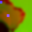

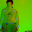

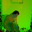

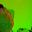

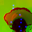

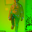

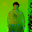

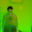

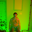

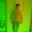

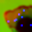

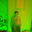

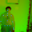

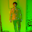

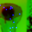

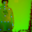

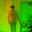

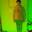

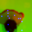

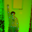

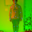

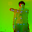

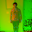

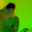

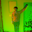

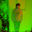

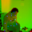

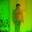

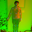

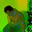

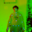

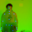

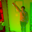

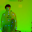

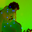

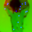

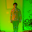

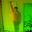

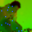

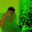

In [9]:
from PIL import Image

test_train_dataset = FESDDataset(RECORDING_DIR, im_size, test_exercises=test_exercises, mode=Mode.FULL_BODY, randomize_augmentation_params=True, use_v2=use_v2)

test_train_loader  = torch.utils.data.DataLoader(test_train_dataset, batch_size=batchsize, shuffle=True)
for pack in test_train_loader:
  merged_images, gt, session = pack
  for merged_image in merged_images:
    bands = []
    for i in range(len("rgb")):
      bands.append(Image.fromarray(merged_image[i].numpy().astype(np.uint8)))
    
    display(Image.merge("RGB", bands))
  break

In [10]:
"""
torchrun --nproc_per_node=8 train.py \
--model $MODEL --batch-size 128 --lr 0.5 --lr-scheduler cosineannealinglr \
--lr-warmup-epochs 5 --lr-warmup-method linear --auto-augment ta_wide --epochs 600 --random-erase 0.1 \
--label-smoothing 0.1 --mixup-alpha 0.2 --cutmix-alpha 1.0 --weight-decay 0.00002 --norm-weight-decay 0.0 \
--train-crop-size $TRAIN_SIZE --model-ema --val-crop-size $EVAL_SIZE --val-resize-size $EVAL_SIZE \
--ra-sampler --ra-reps 4
"""

# epoch number
epochs = 100
# optimizer
optim = 'adam'
# learning rate
learning_rate = 0.005
# learning rate scheduler. can be step, poly or cosine
lr_scheduler = 'cosine'
# warmup epoch
warmup_epoch = 0
# warmup multiplier
warmup_multiplier = 100
# for step scheduler. where to decay lr, can be a list
lr_decay_epochs = [120, 160, 200]
# for step scheduler. step size to decay lr
lr_decay_steps = 20 
# for step scheduler. decay rate for learning rate
lr_decay_rate = 0.01
# weight decay
weight_decay = 0.0001
# momentum for SGD
momentum = 0.9
# gradient clipping margin
clip = 0.5

In [11]:
n_data = len(train_loader.dataset)
CE = torch.nn.CrossEntropyLoss()

if is_cuda:
    CE = CE.cuda()

if all_modes:
    if optim == 'adam':
        optimizer_full_body = torch.optim.Adam(model_full_body.parameters(),    learning_rate, weight_decay=weight_decay)
        optimizer_half_body = torch.optim.Adam(model_half_body.parameters(),    learning_rate, weight_decay=weight_decay)
        optimizer_limbs     = torch.optim.Adam(model_limbs.parameters(),        learning_rate, weight_decay=weight_decay)
        optimizer_joints    = torch.optim.Adam(model_joints.parameters(),       learning_rate, weight_decay=weight_decay)
    elif optim == 'adamW':
        optimizer_full_body = torch.optim.AdamW(model_full_body.parameters(),   learning_rate, weight_decay=weight_decay)
        optimizer_half_body = torch.optim.AdamW(model_half_body.parameters(),   learning_rate, weight_decay=weight_decay)
        optimizer_limbs     = torch.optim.AdamW(model_limbs.parameters(),       learning_rate, weight_decay=weight_decay)
        optimizer_joints    = torch.optim.AdamW(model_joints.parameters(),      learning_rate, weight_decay=weight_decay)
    elif optim == 'sdg':
        optimizer_full_body = torch.optim.SGD(model_full_body.parameters(),     learning_rate / 10.0 * batchsize, momentum=momentum, weight_decay=weight_decay)
        optimizer_half_body = torch.optim.SGD(model_half_body.parameters(),     learning_rate / 10.0 * batchsize, momentum=momentum, weight_decay=weight_decay)
        optimizer_limbs     = torch.optim.SGD(model_limbs.parameters(),         learning_rate / 10.0 * batchsize, momentum=momentum, weight_decay=weight_decay)
        optimizer_joints    = torch.optim.SGD(model_joints.parameters(),        learning_rate / 10.0 * batchsize, momentum=momentum, weight_decay=weight_decay)

    scheduler_full_body     = get_scheduler(optimizer_full_body, len(train_loader_full_body), lr_scheduler, lr_decay_epochs, lr_decay_steps, lr_decay_rate, epochs, warmup_epoch,     warmup_multiplier)
    scheduler_half_body     = get_scheduler(optimizer_half_body, len(train_loader_half_body), lr_scheduler, lr_decay_epochs, lr_decay_steps, lr_decay_rate, epochs, warmup_epoch, warmup_multiplier)
    scheduler_limbs         = get_scheduler(optimizer_limbs, len(train_loader_limbs), lr_scheduler, lr_decay_epochs, lr_decay_steps, lr_decay_rate, epochs, warmup_epoch, warmup_multiplier)
    scheduler_joints        = get_scheduler(optimizer_joints, len(train_loader_joints), lr_scheduler, lr_decay_epochs, lr_decay_steps, lr_decay_rate, epochs, warmup_epoch, warmup_multiplier)
else:
    if optim == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
    elif optim == 'adamW':
        optimizer = torch.optim.AdamW(model.parameters(), learning_rate, weight_decay=weight_decay)
    elif optim == 'sdg':
        optimizer = torch.optim.SGD(model.parameters(), learning_rate / 10.0 * batchsize, momentum=momentum, weight_decay=weight_decay)

    scheduler = get_scheduler(optimizer, len(train_loader), lr_scheduler, lr_decay_epochs, lr_decay_steps, lr_decay_rate, epochs, warmup_epoch, warmup_multiplier)


In [12]:
if all_modes:
    model_iterator = list(zip([Mode.FULL_BODY,          Mode.HALF_BODY,         Mode.LIMBS,         Mode.JOINTS], 
                              [model_full_body,         model_half_body,        model_limbs,        model_joints], 
                              [optimizer_full_body,     optimizer_half_body,    optimizer_limbs,    optimizer_joints], 
                              [scheduler_full_body,     scheduler_half_body,    scheduler_limbs,    scheduler_joints],
                              [train_loader_full_body,  train_loader_half_body, train_loader_limbs, train_loader_joints], 
                              [test_loader_full_body,   test_loader_half_body,  test_loader_limbs,  test_loader_joints]))

In [13]:
model_columns = ["epoch", "iteration", "joint_id",
                  "gts", "preds", "confidences", 
                  "Avg loss", "loss", "accuracy", 
                  "tp", "tn", "fp", "fn", "precision", "recall", "f1", 
                  "cohens_kappa", "learning_rate",
                  "train_test", "exercise", "simplified", "mode", "use_v2"]
                  
df_model = pd.DataFrame(columns=model_columns)
pb = tqdm(range(1, epochs + 1), desc='Epoch')

for epoch in pb:
    if all_modes:    
        print(f"--- {epoch:3d} ---")
        for mode, model, optimizer, scheduler, train_loader, _ in model_iterator:
            tic = time()
            torch.cuda.empty_cache()
            
            loss = train(train_loader, model, optimizer, CE, scheduler, clip, epoch, epochs, is_cuda, mode, df_model, use_v2)  
            last_row = df_model[df_model["epoch"] == epoch][df_model["mode"] == mode.name.lower()].mean(numeric_only=True)
            pb.set_description(f'Epoch (mode: {mode.name.lower().replace("_", " "):>10}, lr: {optimizer.param_groups[0]["lr"]:.3e}, loss: {last_row["Avg loss"]:.3e})')
            
            print(f'Epoch (mode: {mode.name.lower().replace("_", " "):>10}, lr: {optimizer.param_groups[0]["lr"]:.3e}, loss: {last_row["Avg loss"]:.3e}, acc: {last_row["accuracy"]:.3f}, f1: {last_row["f1"]:.3f}, precision: {last_row["precision"]:.3f}, recall: {last_row["recall"]:.3f}, kappa: {last_row["cohens_kappa"]:.3f}, time: {time() - tic:.2f}s)')      

            if (epoch) % 10 == 0:
                torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"{mode.name.lower()}_{epoch}_ckpt.pth")) 
    else:
        tic = time()
        torch.cuda.empty_cache()
        loss = train(train_loader, model, optimizer, CE, scheduler, clip, epoch, epochs, is_cuda, mode, df_model, use_v2)

        pb.set_description(f'Epoch (mode: {mode.name.lower().replace("_", " "):>10}, lr: {optimizer.param_groups[0]["lr"]:.3e}, loss: {loss:.3e})')
        
        if (epoch) % 10 == 0:
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"{epoch}_ckpt.pth"))
    
if all_modes:
    for mode, model, _, _, _, _ in model_iterator:
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"{mode.name.lower()}_last_ckpt.pth")) 
        print(f"model saved {os.path.join(CHECKPOINT_DIR, f'last_ckpt.pth')}!")
else:
    torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"last_ckpt.pth"))
    print(f"model saved {os.path.join(CHECKPOINT_DIR, f'last_ckpt.pth')}!")
    checkpoint = os.path.join(CHECKPOINT_DIR, f"last_ckpt.pth")

df_model.to_parquet('ModelAnalysis.parquet.gzip', compression='gzip') 

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

---   1 ---


KeyboardInterrupt: 

In [ ]:
df_model

,epoch,iteration,joint_id,gts,preds,confidences,Avg loss,loss,accuracy,tp,...,precision,recall,f1,cohens_kappa,learning_rate,train_test,exercise,simplified,mode,use_v2
0,1,1,0,"[0.0, 0.0, 0.0]","[1.0, 1.0, 0.0]","[0.5121623277664185, 0.5606511831283569, 0.508...",0.140238,0.140238,0.333333,1.0,...,1.000000,0.333333,0.5,0.0,0.005000,train,E-2.03,True,full_body,True
1,1,2,0,"[0.0, 0.0, 1.0]","[1.0, 1.0, 1.0]","[0.7705711722373962, 0.8028934001922607, 0.759...",0.708748,1.277259,0.333333,0.0,...,0.000000,0.000000,0.0,0.0,0.005000,train,E-0.00,True,full_body,True
2,1,3,0,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.5, 0.5, 0.5]",0.472499,0.000000,0.666667,2.0,...,0.666667,1.000000,0.8,0.0,0.005000,train,E-1.02,True,full_body,True
3,1,4,0,"[1.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.5, 0.5, 0.5]",0.354374,0.000000,0.333333,1.0,...,0.333333,1.000000,0.5,0.0,0.005000,train,E-3.00,True,full_body,True
4,1,5,0,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.5, 0.5, 0.5]",0.283499,0.000000,0.666667,2.0,...,0.666667,1.000000,0.8,0.0,0.005000,train,E-1.03,True,full_body,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33453,5,134,0,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.5, 0.5, 0.5]",0.000000,0.000000,1.000000,3.0,...,1.000000,1.000000,1.0,NaN,0.004972,train,E-2.03,True,full_body,True
33454,5,135,0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.5, 0.5, 0.5]",0.000000,0.000000,0.666667,2.0,...,0.666667,1.000000,0.8,0.0,0.004972,train,E-2.02,True,full_body,True
33455,5,136,0,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.5, 0.5, 0.5]",0.000000,0.000000,0.666667,2.0,...,0.666667,1.000000,0.8,0.0,0.004972,train,E-2.03,True,full_body,True
33456,5,137,0,"[1.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.5, 0.5, 0.5]",0.000000,0.000000,0.333333,1.0,...,0.333333,1.000000,0.5,0.0,0.004972,train,E-2.00,True,full_body,True


### Test Model

In [ ]:
if all_modes:
  for mode, model, _, _, _, test_loader in model_iterator:
    test(test_loader, model, CE, is_cuda, mode, df_model, use_v2)
else: 
  test(test_loader, model, CE, is_cuda, mode, df_model, use_v2)
  
df_model.to_parquet('ModelAnalysis.parquet.gzip', compression='gzip') 

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [ ]:
df_model.to_parquet('ModelAnalysis.parquet.gzip', compression='gzip') 